# Introdução

Este relatório apresenta uma análise do processo de coleta e processamento de dados, modelagem e avaliação dos modelos de aprendizado de máquina aplicados a um conjunto de dados de reclamações de veículos. O objetivo é discutir o processo da pipeline de transformação utilizada e os resultados obtidos com os modelos escolhidos.
Neste mesmo arquivo será rodado todo o código do modelo para mostrar e detalhar seu funcionamento.

Este diagrama representa o fluxo que foi escolhido e feito para garantir a realização da task.
As etapas e decições tomadas serão  detalhadas e explicadas ao longo deste relatório.

```mermaid
graph TD;
    A[Coleta de Dados] --> B[Processamento dos dados]
    B --> G[Análise Explorátória]
    G --> H[Finalização do Processamento]
    H --> G[Análise Explorátória]
    H --> D[Divisão em Conjuntos]
    D --> E[Treinamento dos Modelos]
    E --> F[Avaliação]

As importações das bibliotecas serão feitas na introdução para que as explicações tenham enfoque em detalhar as decisões tomadas.

In [ ]:
import os
import re
import joblib
import random
import zipfile
import argparse
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import urllib.request
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, precision_recall_curve
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from xgboost import XGBClassifier

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Usuário\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuário\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Usuário\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Coleta de dados

A etapa de coleta de dados pode ser vista individualmente em ./src/data/acquisition.py e o código também está logo abaixo com as explicações

In [31]:
def fetch_data(download_url, output_dir="data/raw"):
    """
    Função que baixa os dados de reclamações a partir de uma URL fornecida usando urllib e descompacta o arquivo ZIP.
    
    Parâmetros:
    download_url: string contendo a url para download
    output_dir: diretório onde será salvo os dados descompactados.
    """
    
    os.makedirs(output_dir, exist_ok=True)

    file_name = download_url.split("/")[-1]
    output_path = os.path.join(output_dir, file_name)
    
    # Nesta linha o os. checa se o arquivo já foi extraido, para que o processo não fique redundante e nem gere cópias desnecessárias
    extracted_files = [f for f in os.listdir(output_dir) if f != file_name]
    
    if extracted_files:
        print(f"Os arquivos já foram extraídos em {output_dir}. Nenhuma ação necessária.")
        return
    
    try:
        # Aqui é utilizado o urllib.request para fazer o download do .zip do DataFrame usando a url  
        urllib.request.urlretrieve(download_url, output_path)
        print(f"Arquivo ZIP salvo em: {output_path}")
        
        # Aqui é utilizado o zipfile para descompactar o .zip do DataFrame
        with zipfile.ZipFile(output_path, 'r') as zip_ref:
            zip_ref.extractall(output_dir)
            print(f"Arquivos descompactados em: {output_dir}")
        
        # Aqui é removido o arquivo .zip que não é mais necessário.
        os.remove(output_path)
        print(f"Arquivo ZIP {file_name} removido.")
    
    except Exception as e:
        print(f"Erro ao baixar ou descompactar os dados: {e}")

# Aqui a função é usada com a url dos dados a serem baixados.
fetch_data("https://static.nhtsa.gov/odi/ffdd/cmpl/COMPLAINTS_RECEIVED_2015-2019.zip")

Os arquivos já foram extraídos em data/raw. Nenhuma ação necessária.


# Processamento dos dados

A etapa de processamento dos dados pode ser vista em conjunto com a etapa de Finalização de Processamento em ./src/data/preprocessing.py e o código de todas as funções utilizadas nessa etapa também está logo abaixo com as explicações.

Abaixo temos o diagrama detalhado do pipeline utilizado no Processamento dos Dados

```mermaid
graph TD
    A[Carregar arquivo CSV] --> B{Verificar se o arquivo existe}
    B -- Sim --> C[Ler o arquivo CSV]
    B -- Não --> D[Erro: Arquivo não encontrado]
    
    C --> E[Renomear colunas]
    E --> F[Limpar texto nas colunas CDESCR e COMPDESC]
    F --> G[Remover colunas desnecessárias]
    
    G --> H{Identificar colunas categóricas e numéricas}
    H --> I[Converter YEARTXT para numérico]
    I --> J[Verificar colunas numéricas INJURED e DEATHS]
    
    J --> K{Converter colunas binárias}
    K --> L[Aplicar transformação nas colunas binárias Y para 1 e N para 0]
    
    L --> M[Aplicar TF-IDF nas colunas de texto CDESCR e COMPDESC]
    M --> N[Transformar e concatenar dados numéricos, categóricos e de texto]
    N --> O[Aplicar pré-processamento: StandardScaler e OneHotEncoder]
    O --> P[Concatenar TF-IDF com dados transformados]
    P --> Q[Salvar arquivo processado em CSV]
    
    Q --> R{Verificar se o arquivo foi salvo corretamente}
    R -- Sim --> S[Arquivo processado salvo com sucesso]
    R -- Não --> T[Erro ao salvar o arquivo]


In [32]:
# Aqui é feito a escolha de idioma para selecionar as stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """
    Função para limpar e pré-processar o texto.
    
    Parâmetros:
    text: string contendo o texto que o usuário deseja processar.

    Retorna:
    Uma string do conjunto dos tokens criados, contendo texto processado e limpo.
    """
    lemmatizer = WordNetLemmatizer()
    
    # Aqui é utilizado o tokenize para transformar o texto que foi convertido para minúsculo em tokens, isso para melhor eficiência na hora de remover as stopwords e lematizar.
    tokens = word_tokenize(text.lower())
    #Aqui é utilizado o lemmatizer e o stopwords para limpar o texto.
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w.isalpha() and w not in stop_words]
    return ' '.join(tokens)

In [33]:
# Está é a função principal de pré-processamento dos dados, onde maior parte das tranformações 
# serão feitas para garantir que todos os dados estejam prontos para o treinamento do modelo.

def process_data(input_file):
    """
    Aplica o pré-processamento e limpeza nos dados para o treinamento ser feito de maneira eficiente e eficaz,
    salva o arquivo processado com as modificações.
    
    Parâmetros:
    input_file: string contendo o path para o arquivo que será feito o pré-processamento e limpeza.
    
    """
    
    if not os.path.exists(input_file):
        print(f"Erro: O arquivo '{input_file}' não foi encontrado.")
        return
    try:
        df = pd.read_csv(input_file)
        print("Arquivo carregado com sucesso! Primeiras linhas:")
        print(df.head())
    except Exception as e:
        print(f"Erro ao ler o arquivo: {e}")
        return
    

    # Aqui todas as colunas foram nomeadas seguindo o CMPL.txt, retirado da aba de Complaints no site da NHTSA.
    df.columns = [
        "CMPLID", "ODINO", "MFR_NAME", "MAKETXT", "MODELTXT", "YEARTXT", "CRASH", "FAILDATE",
        "FIRE", "INJURED", "DEATHS", "COMPDESC", "CITY", "STATE", "VIN", "DATEA", "LDATE", "MILES",
        "OCCURENCES", "CDESCR", "CMPL_TYPE", "POLICE_RPT_YN", "PURCH_DT", "ORIG_OWNER_YN", "ANTI_BRAKES_YN",
        "CRUISE_CONT_YN", "NUM_CYLS", "DRIVE_TRAIN", "FUEL_SYS", "FUEL_TYPE", "TRANS_TYPE", "VEH_SPEED",
        "DOT", "TIRE_SIZE", "LOC_OF_TIRE", "TIRE_FAIL_TYPE", "ORIG_EQUIP_YN", "MANUF_DT", "SEAT_TYPE",
        "RESTRAINT_TYPE", "DEALER_NAME", "DEALER_TEL", "DEALER_CITY", "DEALER_STATE", "DEALER_ZIP", 
        "PROD_TYPE", "REPAIRED_YN", "MEDICAL_ATTN", "VEHICLES_TOWED_YN"
    ]
    
    # Aqui é aplicado o clean_text nas colunas de texto para fazer as operações que foram descritas.
    df["CDESCR"] = df["CDESCR"].astype(str).apply(clean_text)
    df["COMPDESC"] = df["COMPDESC"].astype(str).apply(clean_text)
    
    # Aqui as colunas que foram julgadas desnecessárias para o objetivo dos modelos são dropadas.
    df = df.drop(columns=[ 
        "VIN", "ODINO", "MFR_NAME", "MAKETXT", "CITY", "STATE", "DEALER_NAME", 
        "DEALER_TEL", "DEALER_CITY", "DEALER_STATE", "DEALER_ZIP", "DOT", "TIRE_SIZE", 
        "LOC_OF_TIRE", "SEAT_TYPE", "RESTRAINT_TYPE", "CMPLID", "FAILDATE",
        "DATEA", "LDATE", "MILES", "PURCH_DT", "NUM_CYLS", "VEH_SPEED", "ORIG_EQUIP_YN",
        "MANUF_DT", "REPAIRED_YN"
    ])
    
    
    # Aqui é separado as colunas em categóricas e númericas para fazer as transformações de cada tipo corretamente.
    categorical_columns = ["CMPL_TYPE", "DRIVE_TRAIN", "FUEL_SYS", "FUEL_TYPE", "TRANS_TYPE", "TIRE_FAIL_TYPE", "PROD_TYPE"]

    # Aqui foi feita a conversão da coluna para númerico, pois ela é registrada como char no DataFrame original, é preciso dela como numérico para entrar na normalização.
    df["YEARTXT"] = pd.to_numeric(df["YEARTXT"], errors='coerce')

    numeric_columns = df.select_dtypes(include=['number']).columns.tolist()

    print("As colunas numéricas são: " + ", ".join(numeric_columns))


    if "INJURED" not in numeric_columns:
        print("Coluna 'INJURED' não encontrada nas colunas numéricas. Verifique o tipo da coluna.")
    if "DEATHS" not in numeric_columns:
        print("Coluna 'DEATHS' não encontrada nas colunas numéricas. Verifique o tipo da coluna.")

    # Aqui é onde as colunas que constam com 'Y' para true e 'N' para false são convertidas para binário, sendo agora 1 para 'Y' e 0 para 'N'.
    binary_columns = ["CRASH", "FIRE", "POLICE_RPT_YN", "ORIG_OWNER_YN", "ANTI_BRAKES_YN", 
                      "CRUISE_CONT_YN", "MEDICAL_ATTN", "VEHICLES_TOWED_YN"]
    for col in binary_columns:
        df[col] = df[col].map({'Y': 1, 'N': 0})

 
    
    # Aqui é feito a vetorização das colunas de texto que já estão processadas, gerando 50 novas features com base na importância das palavras. 
    text_columns = ['CDESCR', 'COMPDESC']
    vectorizer = TfidfVectorizer(max_features=50)
    # Aqui as duas colunas de texto são concatenadas para que seja feito apenas uma vetorização.
    combined_text = df[text_columns].apply(lambda x: ' '.join(x), axis=1)
    # Aqui é aplicado o TF-IDF, efetivamente vetorizando a coluna de texto
    tfidf_matrix = vectorizer.fit_transform(combined_text)
    # Aqui a matriz resultante da vetorização é convertida array e então para DataFrame, para poder ser concatenado novamente com o DataFrame principal.
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    
    # Aqui é dropado as colunas de texto que não são mais necessárias.
    df = df.drop(columns=text_columns)

    # Aqui é criado um pré-processador de dados que utiliza o ColumnTransformer, que é uma maneira de aplicar tranformações específicas a determinadas colunas do DataFrame.
    # Neste caso, será utilizado o StandardScaler, que normaliza os dados númericos 
    # e o OneHotEncoder, que é usado para converter variáveis categóricas em colunas binárias.
    preprocessor = ColumnTransformer([ 
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns)
    ])
    # Aqui é aplicado o pré-processador.
    df_transformed = preprocessor.fit_transform(df)
    # Aqui é criado um novo DataFrame usando a matriz tranformada e definindo os nomes das colunas apropriadamente.
    df_transformed = pd.DataFrame(df_transformed, columns= 
                                  numeric_columns + 
                                  list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)))
    
    # Aqui é feito a concatenação do TF-IDF com o restante dos dados transformados
    df_final = pd.concat([df_transformed, tfidf_df, df[binary_columns]], axis=1)

    # Aqui o DataFrame é salvo em .csv
    output_file = input_file.replace("raw", "processed")
    try:
        df_final.to_csv(output_file, index=False)
        print(f"Arquivo processado salvo em: {output_file}")
    except Exception as e:
        print(f"Erro ao salvar o arquivo: {e}")
        return

    if os.path.exists(output_file):
        print(f"Arquivo CSV processado com sucesso: {output_file}")
    else:
        print(f"Erro: O arquivo CSV não foi gerado.")


In [34]:
# Essa é a função que cria a primeira versão processada do .csv a partir dos dados crus .txt e chama a função process_data.
 
def create_processed_file(input_file="data/raw/COMPLAINTS_RECEIVED_2015-2019.txt", output_dir="data/processed"):
    """
    Cria um arquivo processado .csv a partir do arquivo de dados bruto baixado.
    
    Parâmetros:
    input_file: string contendo o path para o arquivo de dados bruto que vai ser processado e transformado em .csv.
    output_dir: string contendo o path para o diretório onde o arquivo processado vai ser criado e salvo.
    """
    
    os.makedirs(output_dir, exist_ok=True)
    
    if not os.path.exists(input_file):
        print(f"Erro: O arquivo '{input_file}' não foi encontrado.")
        return
    
    try:
        df = pd.read_csv(input_file, sep="\t", header=None)
        print("Arquivo carregado com sucesso! Primeiras linhas:")
        print(df.head())
    except Exception as e:
        print(f"Erro ao ler o arquivo: {e}")
        return
    
    consolidated_file = os.path.join(output_dir, "complaints.csv")
    try:
        df.to_csv(consolidated_file, index=False)
        print(f"Arquivo carregado salvo em: {consolidated_file}")
    except Exception as e:
        print(f"Erro ao salvar o arquivo: {e}")
        return
    
    if os.path.exists(consolidated_file):
        print(f"Arquivo CSV gerado com sucesso: {consolidated_file}")
        process_data(consolidated_file)
    else:
        print(f"Erro: O arquivo CSV não foi gerado.")


In [35]:
# Utilizando a função
create_processed_file()

C:\Users\Usuário\AppData\Local\Temp\ipykernel_11756\2761405519.py:19: DtypeWarning: Columns (15,16,18,28,41,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file, sep="\t", header=None)


Arquivo carregado com sucesso! Primeiras linhas:
        0       1                    2    3             4       5  6   \
0  1143612  516612  General Motors, LLC  GMC  ENVOY DENALI  2007.0  N   
1  1143613  516612  General Motors, LLC  GMC  ENVOY DENALI  2007.0  N   
2  1143614  516612  General Motors, LLC  GMC  ENVOY DENALI  2007.0  N   
3  1143615  516612  General Motors, LLC  GMC  ENVOY DENALI  2007.0  N   
4  1143616  516612  General Motors, LLC  GMC  ENVOY DENALI  2007.0  N   

         7  8   9   ...   39                          40   41   42   43   44  \
0  20150825  N   0  ...  NaN  WHITE BEAR LAKE SUPERSTORE  NaN  NaN  NaN  NaN   
1  20150825  N   0  ...  NaN  WHITE BEAR LAKE SUPERSTORE  NaN  NaN  NaN  NaN   
2  20150825  N   0  ...  NaN  WHITE BEAR LAKE SUPERSTORE  NaN  NaN  NaN  NaN   
3  20150825  N   0  ...  NaN  WHITE BEAR LAKE SUPERSTORE  NaN  NaN  NaN  NaN   
4  20150825  N   0  ...  NaN  WHITE BEAR LAKE SUPERSTORE  NaN  NaN  NaN  NaN   

  45   46 47 48  
0  V  NaN  N 

C:\Users\Usuário\AppData\Local\Temp\ipykernel_11756\198929947.py:18: DtypeWarning: Columns (15,16,18,28,41,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file)


Arquivo carregado com sucesso! Primeiras linhas:
         0       1                    2    3             4       5  6  \
0  1143612  516612  General Motors, LLC  GMC  ENVOY DENALI  2007.0  N   
1  1143613  516612  General Motors, LLC  GMC  ENVOY DENALI  2007.0  N   
2  1143614  516612  General Motors, LLC  GMC  ENVOY DENALI  2007.0  N   
3  1143615  516612  General Motors, LLC  GMC  ENVOY DENALI  2007.0  N   
4  1143616  516612  General Motors, LLC  GMC  ENVOY DENALI  2007.0  N   

          7  8  9  ...   39                          40   41   42   43   44  \
0  20150825  N  0  ...  NaN  WHITE BEAR LAKE SUPERSTORE  NaN  NaN  NaN  NaN   
1  20150825  N  0  ...  NaN  WHITE BEAR LAKE SUPERSTORE  NaN  NaN  NaN  NaN   
2  20150825  N  0  ...  NaN  WHITE BEAR LAKE SUPERSTORE  NaN  NaN  NaN  NaN   
3  20150825  N  0  ...  NaN  WHITE BEAR LAKE SUPERSTORE  NaN  NaN  NaN  NaN   
4  20150825  N  0  ...  NaN  WHITE BEAR LAKE SUPERSTORE  NaN  NaN  NaN  NaN   

  45   46 47 48  
0  V  NaN  N  N  
1

# Análise Exploratória

A etapa de análise exploratória pode ser vista individualmente em ./src/data/exploratoryanalysis.py e o código de todas as funções utilizadas nessa etapa também está logo abaixo com as explicações

Está etapa em específico funciona em conjunto da etapa de Finalização do processamento, onde será análisado como estão os dados e a mudanças que restam para que tudo fique em perfeito estado para iniciar o treinamento dos modelos.

In [36]:
def exploratory_analysis(input_file):
    """
    Realiza uma análise exploratória básica dos dados.
    
    Parâmetros:
    input_file: string contendo o path para o arquivo de dados .csv que vai ser utilizado para fazer a análise exploratória.
    """
    if not os.path.exists(input_file):
        print(f"Erro: O arquivo '{input_file}' não foi encontrado.")
        return

    try:
        df = pd.read_csv(input_file, low_memory=False)
    except Exception as e:
        print(f"Erro ao carregar o arquivo: {e}")
        return

    # Aqui exibe as primeiras linhas
    print("\nPrimeiras linhas do dataset:")
    print(df.head())

    # Aqui é mostrado as informações gerais
    print("\nInformações gerais do dataset:")
    print(df.info())

    # Aqui é exibe as estatísticas descritivas
    print("\nEstatísticas descritivas:")
    print(df.describe(include=['number']))

    # Aqui é mostrado a soma dos valores ausentes por coluna
    # É liberado também o limite de linhas mostradas para que a análise de valores nulos seja precisa.
    pd.set_option('display.max_rows', None)
    print("\nValores ausentes por coluna:")
    print(df.isnull().sum())


In [37]:
# Aqui o path do DataFrame é atribuido para fazer a análise exploratória
input_file = "data/processed/complaints.csv"


In [38]:
exploratory_analysis(input_file)


Primeiras linhas do dataset:
    YEARTXT   INJURED    DEATHS  CMPL_TYPE_CON  CMPL_TYPE_DP  CMPL_TYPE_EVOQ  \
0 -0.113268 -0.140078 -0.011693            0.0           0.0             1.0   
1 -0.113268 -0.140078 -0.011693            0.0           0.0             1.0   
2 -0.113268 -0.140078 -0.011693            0.0           0.0             1.0   
3 -0.113268 -0.140078 -0.011693            0.0           0.0             1.0   
4 -0.113268 -0.140078 -0.011693            0.0           0.0             1.0   

   CMPL_TYPE_IVOQ  CMPL_TYPE_LETR  CMPL_TYPE_MAVQ  CMPL_TYPE_MIVQ  ...  wheel  \
0             0.0             0.0             0.0             0.0  ...    0.0   
1             0.0             0.0             0.0             0.0  ...    0.0   
2             0.0             0.0             0.0             0.0  ...    0.0   
3             0.0             0.0             0.0             0.0  ...    0.0   
4             0.0             0.0             0.0             0.0  ...    0.0   

  

A partir dessa primeira análise é possível perceber que o pré-processamento de dados foi um sucesso, gerando as novas features a partir das colunas de texto e normalizando os dados numéricos, entretanto algumas colunas (YEARTXT, POLICE_RPT_YN, ORIG_OWNER_YN, ANTI_BRAKES_YN, CRUISE_CONT_YN, MEDICAL_ATTN, VEHICLES_TOWED_YN) ainda estão com valores nulos, é possível ver também que durante o OneHotEncoder ele gerou colunas _nan, que representam valores que estavam NaN no DataFrame original, logo não são necessárias para o treinamento dos modelos. Portanto iremos fazer mais um leve pré-processamento com objetivo de que o DataFrame esteja pronto para o treino.

In [39]:
def plot_valid_counts(input_file):
    """
    Gera um gráfico de barras mostrando a quantidade de valores válidos (não nulos) em cada coluna.
    
    Parâmetros:
    input_file: string contendo o path para o arquivo de dados .csv que vai ser utilizado para plotar o gráfico.
    """
    if not os.path.exists(input_file):
        print(f"Erro: O arquivo '{input_file}' não foi encontrado.")
        return

    try:
        df = pd.read_csv(input_file)
        print("Arquivo carregado com sucesso!")
    except Exception as e:
        print(f"Erro ao carregar o arquivo: {e}")
        return

    # Aqui é contado os valores válidos (não nulos) em cada coluna.
    valid_counts = df.notnull().sum()

    # Aqui é plotado o gráfico usando o matplotlib.
    plt.figure(figsize=(12, 6))
    valid_counts.sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title("Quantidade de Valores Válidos por Coluna", fontsize=16)
    plt.xlabel("Colunas", fontsize=12)
    plt.ylabel("Quantidade de Valores Válidos", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


Arquivo carregado com sucesso!


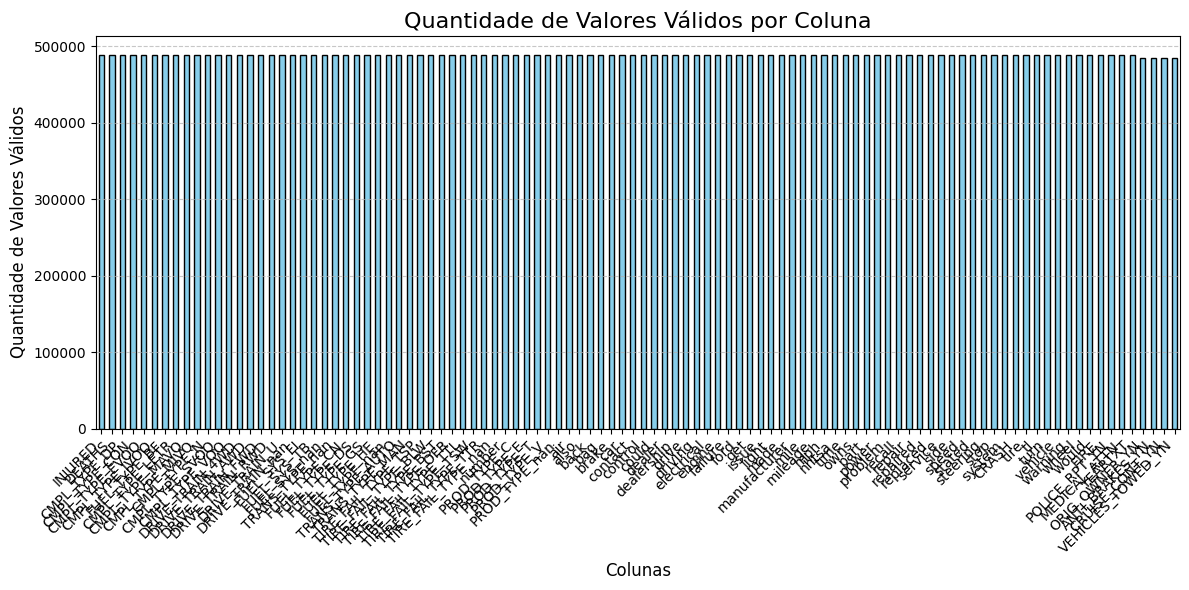

In [40]:
plot_valid_counts(input_file)

Podemos ver no canto direito do gráfico que de fato as colunas estão com menos valores, não é uma grande diferença, mas para garantir que os resultados sejam os melhores possíveis, faremos esse tratmento.

In [41]:
def show_unique_values(input_file):
    """
    Mostra os valores únicos de cada variável.
    
    Parâmetros:
    input_file: string contendo o path para o arquivo de dados .csv que vai ser utilizado para verificar os valores únicos de cada
    variável.
    """

    if not os.path.exists(input_file):
        print(f"Erro: O arquivo '{input_file}' não foi encontrado.")
        return

    try:
        df = pd.read_csv(input_file)
    except Exception as e:
        print(f"Erro ao carregar o arquivo: {e}")
        return

    # Aqui é selecionado apenas as colunas numéricas
    numeric_columns = df.select_dtypes(include=['number']).columns

    pd.set_option('display.max_rows', 10)

    # Aqui mostra os valores únicos de cada variável numérica
    for col in numeric_columns:
        print(f"\nValores únicos em {col}:")
        unique_values = df[col].value_counts().sort_index()
        print(unique_values)

    print("\nValores únicos de todas as variáveis numéricas foram exibidos.")

In [42]:
# Aqui podemos ver alguns dos valores únicos de cada coluna
show_unique_values(input_file)


Valores únicos em YEARTXT:
YEARTXT
-0.167695        2
-0.166537        1
-0.161905        3
-0.160747        2
-0.159589        1
             ...  
-0.101687    18729
-0.100529    13346
-0.099371     6526
-0.098213      385
 9.141665     5782
Name: count, Length: 58, dtype: int64

Valores únicos em INJURED:
INJURED
-0.140078      471394
 2.618971       13219
 5.378019        3026
 8.137067         784
 10.896116        303
                ...  
 68.836131          1
 82.631373          1
 104.703760         1
 137.812341         1
 273.005711         1
Name: count, Length: 21, dtype: int64

Valores únicos em DEATHS:
DEATHS
-0.011693      488327
 5.263059         563
 10.537811         93
 15.812563         11
 26.362068          2
                ...  
 63.285332          1
 210.978390         1
 237.352150         1
 263.725910         1
 522.188761         1
Name: count, Length: 12, dtype: int64

Valores únicos em CMPL_TYPE_CON:
CMPL_TYPE_CON
0.0    488282
1.0       724
Name: count

# Finalização do Processamento

A etapa de finalização do processamento pode ser vista em conjunto com a etapa de Processamento de Dados em ./src/data/preprocessing.py e o código das funções utilizadas nessa etapa também está logo abaixo com as explicações

In [43]:
# Carregando o DataFrame para as transformações que restam.
df = pd.read_csv("data/processed/complaints.csv")

In [44]:
# Aqui aproveitamos que o df foi carregado para fazer uma verificação extra na normalização dos dados.
print(df[['YEARTXT', 'INJURED', 'DEATHS']].mean())
print(df[['YEARTXT', 'INJURED', 'DEATHS']].std())

YEARTXT   -1.763432e-16
INJURED    6.021376e-17
DEATHS     5.700982e-17
dtype: float64
YEARTXT    1.000001
INJURED    1.000001
DEATHS     1.000001
dtype: float64


Como a média está em torno de 0 e o desvio padrão está muito próximo de 1, sabemos que a normalização com o StandardScaler foi bem sucedida.

Agora sim, iremos finalizar as últimas transformações que restam para que o DataFrame fique pronto para uso.

In [45]:
# Aqui iremos utilizar o SimpleImputer para preencher os valores nulos nas colunas.

def impute_missing_values(df):
    """
    Função que realiza imputação de valores ausentes nas colunas numéricas
    e categóricas, e salva as alterações no DataFrame.
    
    Parâmetros:
    df: DataFrame com dados a serem imputados.
    
    Retorna:
    df: DataFrame com valores ausentes imputados.
    """
    
    # Aqui é identificado as colunas numéricas e categóricas
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns

    # Aqui vai ser verificado se há colunas categóricas antes de tentar imputação,
    if len(categorical_cols) > 0:
        print(f"Colunas categóricas encontradas: {categorical_cols}")
    else:
        print("Nenhuma coluna categórica encontrada.")

    for col in categorical_cols:
        print(f"Valores ausentes na coluna {col}: {df[col].isna().sum()}")

        # Aqui é garantido que as colunas categóricas estão no tipo 'category'
        df[col] = df[col].astype('category')

    # Aqui é feito a imputação para colunas numéricas e categóricas,
    # nas númericas utilizamos a estratégia "mean" para que os valores adicionados tenham a média dos valores da coluna
    numerical_imputer = SimpleImputer(strategy='mean')
    # Aqui implementamos efetivamente a imputação nas colunas numéricas
    df[numerical_cols] = numerical_imputer.fit_transform(df[numerical_cols])

    # Aqui fazemos mais uma verificação de se existem colunas categóricas
    if len(categorical_cols) > 0:
        # nas colunas categóricas utilizamos a estratégia "most_frequent" para que os valores adicionados sejam iguais ao valor mais frequente
        categorical_imputer = SimpleImputer(strategy='most_frequent')
        # Preenchendo os valores ausentes nas colunas categóricas
        df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

    return df

In [46]:
# Aqui temos a maneira de utilizar a função
df_imputado = impute_missing_values(df)

Nenhuma coluna categórica encontrada.


No caso do nosso DataFrame, não temos mais colunas catégoricas, porém mantive as condições para caso seja utilizado uma outra estrátegia sem usar o OneHotEncoder.

In [47]:
# Nesta função lidamos com as colunas _nan que foram criadas pelo OneHotEncoder.

def removing_nan(df):
    """
    Remove colunas do DataFrame que contêm '_nan' no nome.

    Parâmetros:
    df: O DataFrame original.

    Retorna:
    df: O DataFrame sem as colunas dos valores NaN
    """
    # Identificar colunas que contêm '_nan' no nome
    colunas_com_nan = [col for col in df.columns if '_nan' in col]
    
    # Dropar as colunas diretamente no DataFrame original
    df.drop(columns=colunas_com_nan, inplace=True)

    return df

In [48]:
# Aqui aplicamos a função para remover as colunas desnecessárias criadas pelo OneHotEncoder.
df_completo = removing_nan(df_imputado)
# E aqui finalmente salvamos o nosso DataFrame com o pré-processamento finalizado.
df_completo.to_csv("data/processed/complaints.csv", index=False)

# Análise Exploratória 2

Esta etapa é identica a primeira Análise Exploratória, iremos somente revisar o DataFrame agora com valores imputados e sem as colunas _nan

In [49]:
exploratory_analysis(input_file)


Primeiras linhas do dataset:
    YEARTXT   INJURED    DEATHS  CMPL_TYPE_CON  CMPL_TYPE_DP  CMPL_TYPE_EVOQ  \
0 -0.113268 -0.140078 -0.011693            0.0           0.0             1.0   
1 -0.113268 -0.140078 -0.011693            0.0           0.0             1.0   
2 -0.113268 -0.140078 -0.011693            0.0           0.0             1.0   
3 -0.113268 -0.140078 -0.011693            0.0           0.0             1.0   
4 -0.113268 -0.140078 -0.011693            0.0           0.0             1.0   

   CMPL_TYPE_IVOQ  CMPL_TYPE_LETR  CMPL_TYPE_MAVQ  CMPL_TYPE_MIVQ  ...  wheel  \
0             0.0             0.0             0.0             0.0  ...    0.0   
1             0.0             0.0             0.0             0.0  ...    0.0   
2             0.0             0.0             0.0             0.0  ...    0.0   
3             0.0             0.0             0.0             0.0  ...    0.0   
4             0.0             0.0             0.0             0.0  ...    0.0   

  

Vemos aqui que não tem mas nenhum valor ausente e que as colunas geradas pelos NaN foram definitivamente excluidas

Arquivo carregado com sucesso!


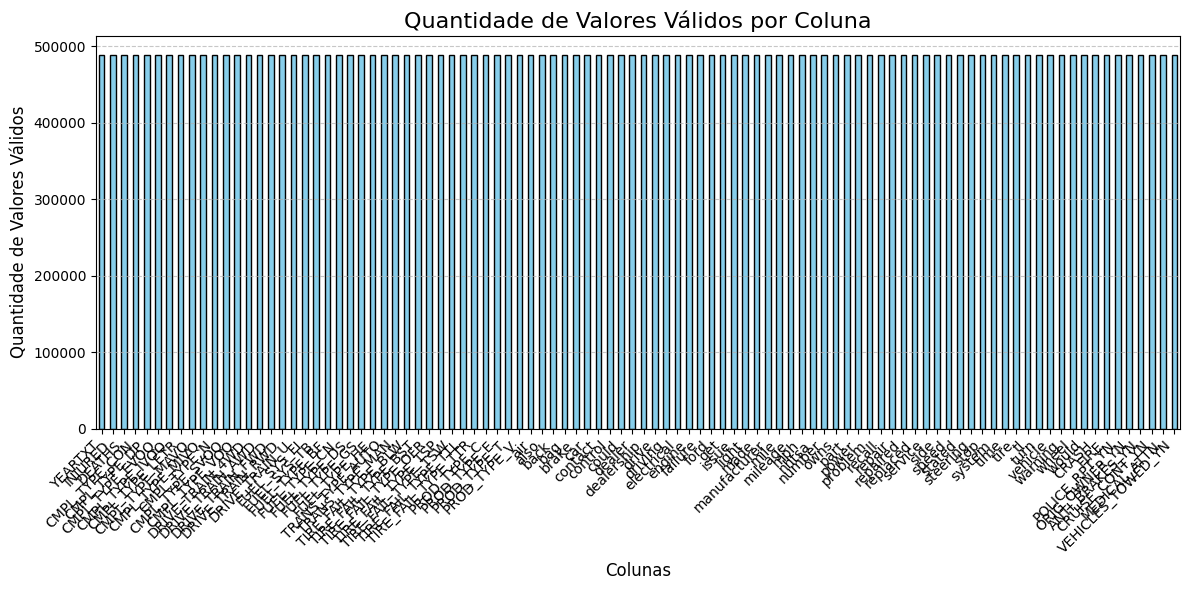

In [50]:
plot_valid_counts(input_file)

Agora o canto direito do gráfico se iguala com todas as outras colunas

# Divisão em Conjuntos

A etapa de Divisão de Conjuntos pode ser vista em conjunto com a etapa de Processamento de Dados e Finalização de Processamento em ./src/data/preprocessing.py e o código das funções utilizadas nessa etapa também está logo abaixo com as explicações

In [3]:
# Aqui fazemos outro carregamento do DataFrame, para garantir.
df_treino = pd.read_csv("data/processed/complaints.csv")

In [4]:
# Aqui na é feita a divisão dos dados de treino e teste e a definição dos modelos que serão utilizados no treinamento.

def prepare_models_and_split(df):
    """
    Função para preparar os dados e definir os modelos, 
    realizando a divisão de treino e teste.

    Parâmetros:
    df: DataFrame contendo os dados.

    Retorna:
    models: Dicionário com os modelos prontos para treino.
    X_train, X_test, y_train, y_test: Conjuntos de dados divididos para treino e teste.
    """

    # Aqui é feita a definição do target (y) e das features (X).
    y = df["MEDICAL_ATTN"]
    X = df.drop(columns=["MEDICAL_ATTN"])

    # Aqui fazemos aransformação para binário (1 = positivo, 0 = negativo) do target, pois é uma classificação binária.
    y = (y > 0).astype(int)

    # Aqui é feita a divisão de treino e teste, separando 20% dos dados para o teste.
    test_size = 0.2
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Aqui temos os 3 modelos que serão utilizados. Todos os parâmetros dos modelos foram pensados para tentar evitar o overfit.
    models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=15,  # Este parâmetros é muito importante pois evita árvores muito profundas, reduzindo overfitting.
        min_samples_split=20, 
        min_samples_leaf=10,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    
    "Logistic Regression": LogisticRegression(
        random_state=42,
        max_iter=5000,
        C=0.5,  # Aqui setamos uma regularização mais forte para evitar overfitting
        solver='saga',
        n_jobs=-1
    ),

    "XGBoost": XGBClassifier(
        n_estimators=200,
        learning_rate=0.03,
        max_depth=15,  # Aqui mantemos a profundidade da árvore igual ao Random Forest, pelo mesmo motivo.
        subsample=0.7, 
        colsample_bytree=0.7,
        scale_pos_weight=1.0,  
        eval_metric='logloss',  # Aqui setamos a métrica comummente utilizada para classificação binária.
        tree_method='hist',  # Usa histograma para acelerar o treinamento
        random_state=42,
        n_jobs=-1
    )
}

    return models, X_train, X_test, y_train, y_test

In [5]:
# Executando a divisão de dados e implementação dos modelos.
models, X_train, X_test, y_train, y_test = prepare_models_and_split(df_treino)

# Treinamento dos Modelos

A etapa de Treinamento dos Modelo pode ser vista individualmente em ./src/data/train_test.py e o código das funções utilizadas nessa etapa também está logo abaixo com as explicações

Agora com todas as "ferramentas em mãos" vamos treinar os modelos 

No treinamento foi utilizado o Voting Classifier, para garantir uma maior robustez dos resultdos combinando as previsões dos modelo escolhidos, e pelo fato da abordagem do Logistic Regression ser diferente dos outros modelos, o Voting Classifier mostra ainda mais o seu valor.

In [54]:
# Nesta função usamos o tqdm, para fazer uma breve barra de progresso no treinamento.

def train_and_evaluate(models, X_train, y_train, X_test, y_test):
    """
    Função para treinar e avaliar todos os modelos selecionados, incluindo um Voting Classifier.

    Parâmetros:
    models: Dicionário com os modelos individuais.
    X_train, X_test, y_train, y_test: Conjuntos de dados divididos para treino e teste.

    Retorna:
    results: Dicionário com os resultados de todos os modelos e do Voting Classifier.
    """

    results = {}

    # Aqui é feito o treino dos modelos.
    total_steps = len(models) + 1  # +1 para o Voting Classifier
    with tqdm(total=total_steps, desc="Treinando modelos", unit="modelo") as pbar:
        for name, model in models.items():
            # Aqui temos o treinamento do modelo.
            model.fit(X_train, y_train)

            # Aqui é feita a prrevisão e cálculo das métricas.
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

            # Aqui é a listagem de todas as métricas que serão utilizadas pelos 3 modelos tradicionais.
            results[name] = {
                "Accuracy": accuracy_score(y_test, y_pred),
                "Precision": precision_score(y_test, y_pred, average='weighted'),
                "Recall": recall_score(y_test, y_pred, average='weighted'),
                "F1-score": f1_score(y_test, y_pred, average='weighted'),
            }

            # Aqui fazemos o calcúlo do AUC-ROC
            if y_prob is not None:
                results[name]["AUC-ROC"] = roc_auc_score(y_test, y_prob)

            pbar.set_postfix(model=name + " concluído")
            pbar.update(1)

        # Aqui é criado o Voting Classifier usando os modelos já treinados.
        voting_clf = VotingClassifier(
            estimators=[(name, model) for name, model in models.items()],
            voting='soft',
            n_jobs=-1
        )

        # Aqui é o treino do Voting Classifier.
        voting_clf.fit(X_train, y_train)

        # Aqui são as previsões e cálculos das métricas para o ensemble.
        y_pred_voting = voting_clf.predict(X_test)
        y_prob_voting = voting_clf.predict_proba(X_test)[:, 1]

        # Aqui temos a lista de todas as métricas que serão utilizadas pelo Voting Classifier
        results["Voting Classifier"] = {
            "Accuracy": accuracy_score(y_test, y_pred_voting),
            "Precision": precision_score(y_test, y_pred_voting, average='weighted'),
            "Recall": recall_score(y_test, y_pred_voting, average='weighted'),
            "F1-score": f1_score(y_test, y_pred_voting, average='weighted'),
            "AUC-ROC": roc_auc_score(y_test, y_prob_voting)
        }

        pbar.set_postfix(model="Voting Classifier concluído")
        pbar.update(1)

    return results

Seria uma possibilidade, retornar também o modelo do Voting Classifier, para poder também usa-lo posteriormente.

In [55]:
# Executando o treinamento e guardando os resultados.
results = train_and_evaluate(models, X_train, y_train, X_test, y_test)

Treinando modelos: 100%|██████████| 4/4 [35:20<00:00, 530.10s/modelo, model=Voting Classifier concluído]  


In [24]:
# Esta função mostra os resultados do treinamento de todos os modelos.

def show_results(results):
    """
    Função para exibir os resultados de avaliação dos modelos.

    Parâmetros:
    results: Dicionário com os resultados, onde a chave é o nome do modelo 
             e o valor é outro dicionário com as métricas e seus valores.
    """
    for model, metrics in results.items():
        print(f"\n{model}:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")


In [57]:
show_results(results)


Random Forest:
Accuracy: 0.9891
Precision: 0.9920
Recall: 0.9891
F1-score: 0.9900
AUC-ROC: 0.9963

Logistic Regression:
Accuracy: 0.9904
Precision: 0.9905
Recall: 0.9904
F1-score: 0.9905
AUC-ROC: 0.9948

XGBoost:
Accuracy: 0.9934
Precision: 0.9936
Recall: 0.9934
F1-score: 0.9935
AUC-ROC: 0.9972

Voting Classifier:
Accuracy: 0.9918
Precision: 0.9924
Recall: 0.9918
F1-score: 0.9920
AUC-ROC: 0.9967


Com esses resultados podemos perceber que os scores de todas métricas de todos os modelos foram ótimos e semelhantes, isso significa que fizemos um bom processamento de dados, mas é bom relembrar que a task não era uma classificação difícil de se fazer, portanto bons resultados já eram esperados desde o início. Outro ponto a se observar é que o Voting Classifier está funcionando como esperando, tendo todos os valores ótimos, porém podemos notar que os ganhos sobre os outros modelos são pequenos pois todos estão bons.

# Avaliação


A etapa de avaliação pode ser vista em conjunto da etapa de Análise Exploratória em ./src/data/exploratoryanalysis.py e em ./src/data/train_test.py, nas funções será dito em qual arquivo estão e o código de todas as utilizadas nessa etapa também está logo abaixo com as explicações

Nesta etapa discutiremos o resultados atráves de alguns gráficos sobre as métricas, além de testar diretamente.
Importante evidenciar que a ideia inical do projeto era escolher o melhor modelo entre os 3, mas com resultados tão bons e tão parecidos, vamos ter que checar individualmente alguns quesitos para por fim, declarar qual o melhor modelo para o contexto da task, que é classificar se uma situação vai precisar ou não de atendimento médico.

In [8]:
# Se encontra em ./train_test.py
# Esta função vai salvar todos os modelos que foram escolhidos para poderem ser usados posteriormente.

def save_models(models, output_dir="models"):
    """
    Função que salva todos os modelos treinados em .pkl

    Parâmetros:
    models: dicionário com os modelos treinados
    output_dir: string com o path do diretório onde os modelos serão salvos.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    for model_name, model in models.items():
        model_file = os.path.join(output_dir, f"{model_name.replace(' ', '_')}.pkl")
        
        try:
            # Aqui usamos o joblib para salvar o modelo
            joblib.dump(model, model_file)
            print(f"Modelo {model_name} salvo em: {model_file}")
        except Exception as e:
            print(f"Erro ao salvar o modelo {model_name}: {e}")

In [59]:
# Aqui salvamos os modelos selecionados anteriormente
save_models(models)

Modelo Random Forest salvo em: models\Random_Forest.pkl
Modelo Logistic Regression salvo em: models\Logistic_Regression.pkl
Modelo XGBoost salvo em: models\XGBoost.pkl


Agora podemos carregar os modelos para usar em testes separadamente, sem precisar treina-los novamente

In [7]:
# Se encontra em ./train_test.py
# Esta função vai fazer o carregamento dos modelos e deixa-los pronto para uso

def load_model(model_name, input_dir="models"):
    """
    Função que carrega os modelos salvos para serem utilizados.

    Parâmetros:
    model_name: Nome(s) do modelo que deseja ser carregado para utilização.
    input_dir: string com path para o diretório onde os modelos serão encontrados.

    Retorna:
    model: Modelo carregado e pronto para utilização.
    """
    
    model_file = os.path.join(input_dir, f"{model_name.replace(' ', '_')}.pkl")
    
    try:
        # Aqui usamos novamente o joblib, mas agora para carregar o modelo
        model = joblib.load(model_file)
        print(f"Modelo {model_name} carregado de: {model_file}")
        return model
    except Exception as e:
        print(f"Erro ao carregar o modelo {model_name}: {e}")
        return None


Com a função load_model, podemos fazer o load individual de cada modelo manualmente, mas como isso não é efetivo para os testes, temos a função logo abaixo:

In [9]:
# Se encontra em ./train_test.py
# Esta função irá carregar todos os modelos de uma única vez, o usuário precisará colocar os nomes dos modelos desejados 
# e para testar a função só precisará ter os dados já separados em treino e teste para ter as variáveis necessárias.
# Depois a função pede apenas o índice do elemento que vai ser classificado por todos os modelos. 
# Este tipo de função é apenas um esboço da efetividade dos modelos nos dados, trazendo os resultados críticos rapidamente. 

def test_all_models(idx, X=X_test, y=y_test, models_dir="models"):
    """
    Testa todos os modelos carregados e compara a previsão com o valor real do target.
    
    Parâmettros:
    idx: Indíce colocado manualmente pelo usuário que vai indicar o elemento do conjunto de dados que vai ser testado.
    X: Recebe por padrão X_test que refere-se aos dados gerais utilizados para teste.
    y: Recebe por padrão y_test que refere-se aos dados do target utilizados para teste.
    models_dir: String contendo o path para o diretório onde se encontram os modelos.

    Retorna:
    results: Dicionário com todos os resultados de todos os modelos que foram testados.
    """
    
    if idx < 0 or idx >= len(X):
        return {"Erro": f"Índice {idx} fora do intervalo válido. O valor de idx deve ser entre 0 e {len(X)-1}"}
    
    # Aqui carregamos os modelos usando a função load_model
    models = {}
    model_names = ["Logistic_Regression", "Random_Forest", "XGBoost"] 
    
    for model_name in model_names:
        model = load_model(model_name, models_dir)
        if model is not None:
            models[model_name] = model
    
    X_single = X.iloc[[idx]]  
    y_single = y.iloc[idx]  # O valor real do target para esse exemplo
    
    
    results = {}
    
    # Aqui nos percorremos sobre os modelos e fazemos as previsões
    for name, model in models.items():
        try:
            y_pred = model.predict(X_single)
            
            # Verificamos se a previsão foi correta
            is_correct = y_pred[0] == y_single
            
            results[name] = {
                "Predição": y_pred[0],
                "Valor Real": y_single,
                "Acerto": is_correct
            }
        except Exception as e:
            results[name] = {"Erro": str(e)}
    
    return results

In [ ]:

# Aqui, por fins de testar facilmente geramos um índice aleatório entre 0 e o número máximo de linhas
num_rows = len(X_test)
idx = random.randint(0, num_rows - 1)
print(idx)

result = test_all_models(idx)

show_results(result)

50027
Modelo Logistic_Regression carregado de: models\Logistic_Regression.pkl
Modelo Random_Forest carregado de: models\Random_Forest.pkl
Modelo XGBoost carregado de: models\XGBoost.pkl

Logistic_Regression:
Predição: 1.0000
Valor Real: 1.0000
Acerto: 1.0000

Random_Forest:
Predição: 1.0000
Valor Real: 1.0000
Acerto: 1.0000

XGBoost:
Predição: 1.0000
Valor Real: 1.0000
Acerto: 1.0000


Daremos uma olhada nas features mais importantes para cada modelo, para entender melhor de onde veio cada resultado

Modelo Logistic_Regression carregado de: models\Logistic_Regression.pkl
Modelo Random_Forest carregado de: models\Random_Forest.pkl
Modelo XGBoost carregado de: models\XGBoost.pkl
Logistic_Regression não possui importância das features.


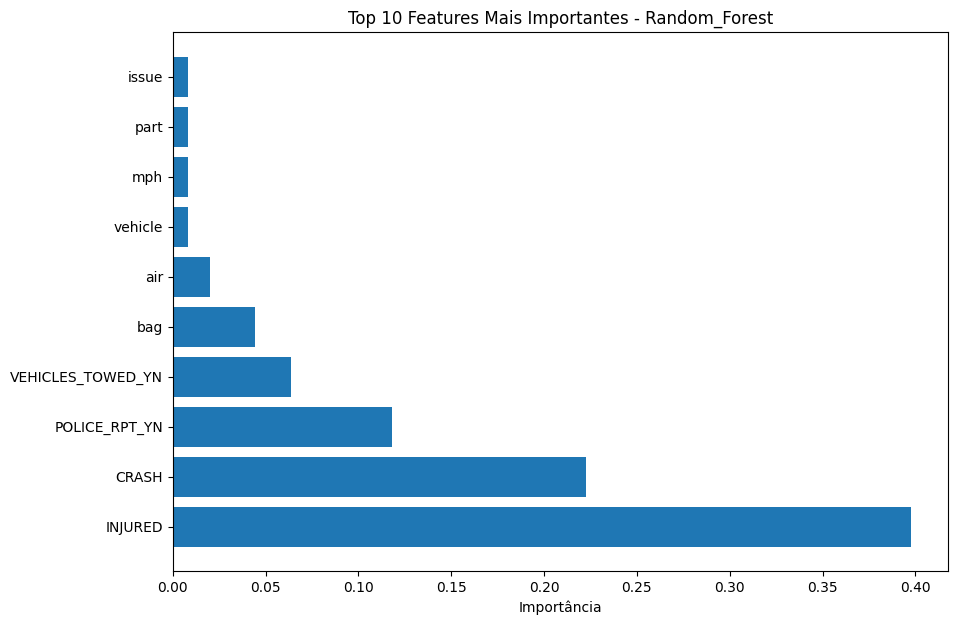

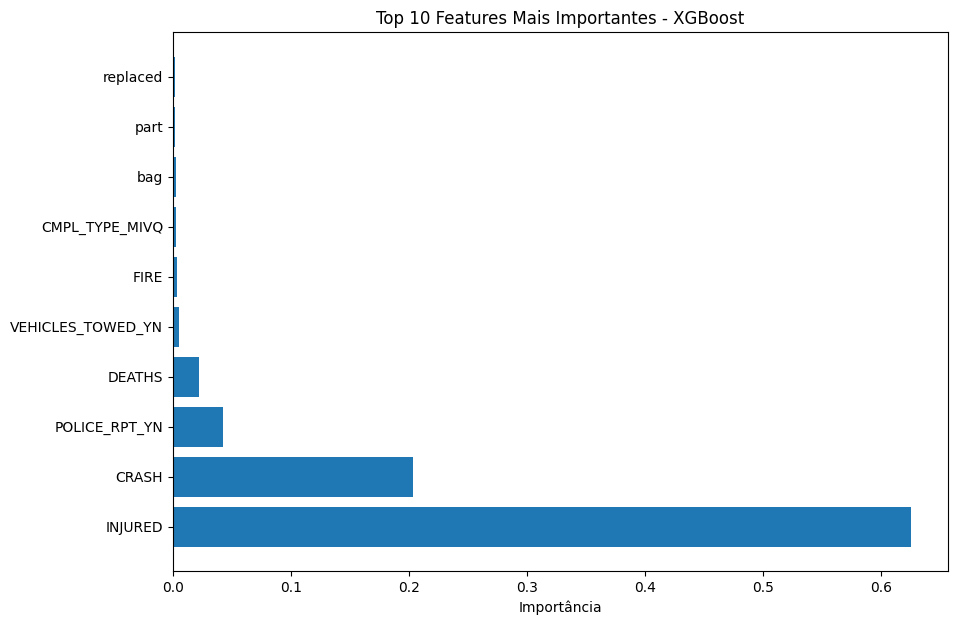

{}

In [ ]:
# Se encontra em ./exploratoryanalysis.py
# Esta função utiliza uma propriedade chamada .feature_importances_ de cada modelo para descobrirmos quis colunas influenciaram mais no treinamento de cada modelo

def plot_feature_importance(models_dir="models", X_train=X_train):
    """
    Plota a importância das features para todos os modelos carregados, mostrando apenas as 10 features mais importantes.

    Parâmetros:
    models_dir: Diretório onde os modelos estão armazenados.
    X_train: Dados de treinamento.
    """
    models = {}
    model_names = ["Logistic_Regression", "Random_Forest", "XGBoost"]

    for model_name in model_names:
        model = load_model(model_name, models_dir)
        if model is not None:
            models[model_name] = model
    
    results = {}

    for name, model in models.items():
        try:
            if hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
                feature_names = X_train.columns

                # Seleciona as 10 features mais importantes
                top_10_indices = importances.argsort()[-10:][::-1] 
                top_10_importances = importances[top_10_indices]   
                top_10_feature_names = feature_names[top_10_indices]  

                # Plota o gráfico
                plt.figure(figsize=(10, 7))
                plt.barh(top_10_feature_names, top_10_importances)
                plt.xlabel('Importância')
                plt.title(f'Top 10 Features Mais Importantes - {name}')
                plt.show()
            else:
                print(f"{name} não possui importância das features.")
        
        except Exception as e:
            results[name] = {"Erro": str(e)}
    
    return results

plot_feature_importance()

O Logistic Regression infelizmente não possui a propriedade de mostrar as features mais importante, mas com base no outros dois modelos, vemos que as três features mais importantes são as mesmas, isso diz muito sobre a maneira que os dois modelos funcionam e também nos indica um processamento de dados bem feito.

Agora checaremos os gráficos dos modelos, para compara-los entre si e decididir qual o melhor modelo pra nossa task.

Modelo Logistic_Regression carregado de: models\Logistic_Regression.pkl
Modelo Random_Forest carregado de: models\Random_Forest.pkl
Modelo XGBoost carregado de: models\XGBoost.pkl


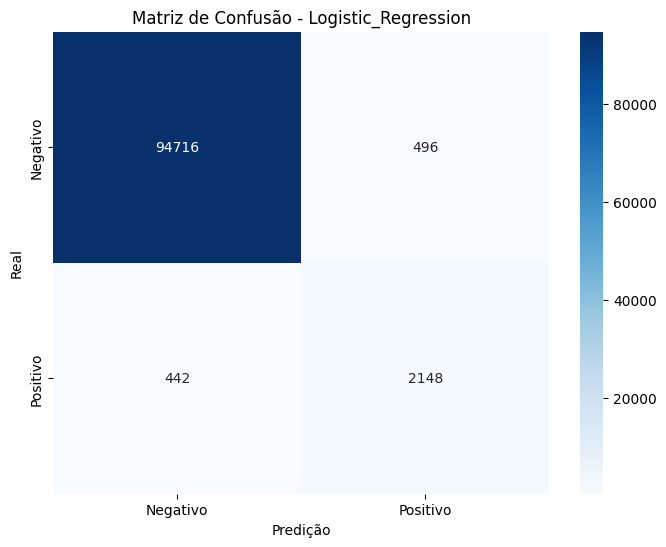

Modelo: Logistic_Regression
TP (Verdadeiro Positivo): 94716
FN (Falso Negativo): 496
FP (Falso Positivo): 442
TN (Verdadeiro Negativo): 2148
----------------------------------------


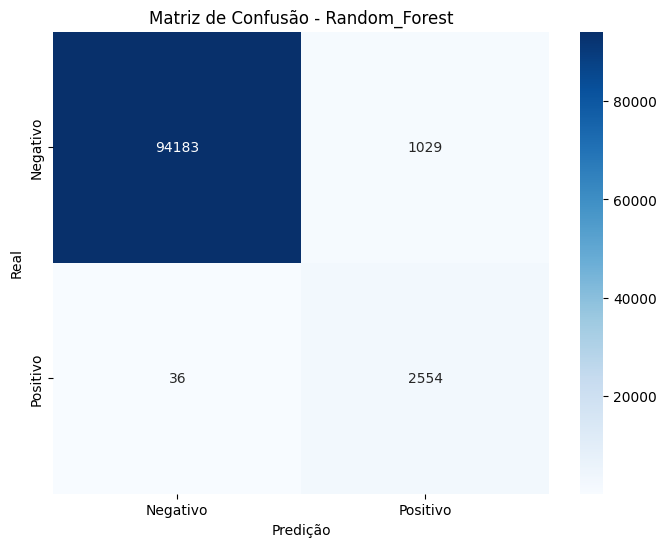

Modelo: Random_Forest
TP (Verdadeiro Positivo): 94183
FN (Falso Negativo): 1029
FP (Falso Positivo): 36
TN (Verdadeiro Negativo): 2554
----------------------------------------


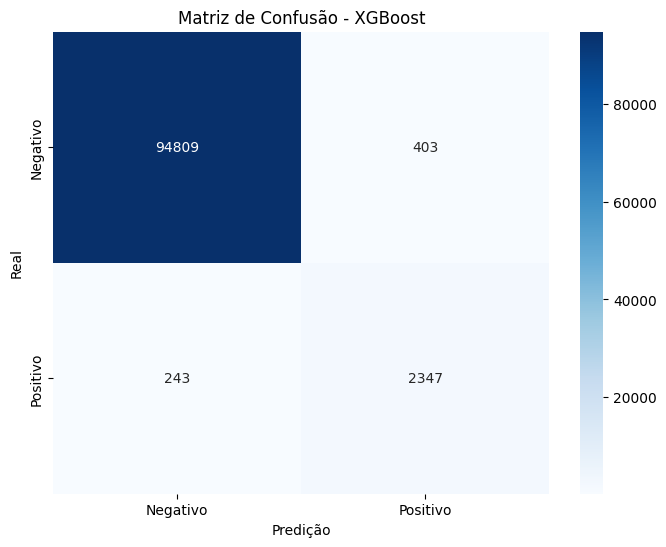

Modelo: XGBoost
TP (Verdadeiro Positivo): 94809
FN (Falso Negativo): 403
FP (Falso Positivo): 243
TN (Verdadeiro Negativo): 2347
----------------------------------------


In [10]:
# Se encontra em ./exploratoryanalysis.py
# Esta função vai nos gerar uma Matriz de Confusão, que nos mostra os valores de TP (Verdadeiros Positivos), FN (Falsos Negativos), FP (Falsos Positivos) e TN (Verdadeiros Negativos)
# de cada modelo.

def plot_confusion_matrix(X=X_test, y=y_test, models_dir="models"):
    """
    Plota a matriz de confusão para todos os modelos carregados e exibe os valores de TP, FN, FP, TN de cada um.
    
    Parâmetros:
    X: Dados de entrada (padrão: X_test).
    y: Dados de saída (padrão: y_test).
    models_dir: Diretório onde os modelos estão salvos.
    
    Retorna:
    None: Exibe a matriz de confusão e os valores de TP, FN, FP, TN de cada modelo.
    """
    models = {}
    model_names = ["Logistic_Regression", "Random_Forest", "XGBoost"] 
    
    for model_name in model_names:
        model = load_model(model_name, models_dir)
        if model is not None:
            models[model_name] = model

    for name, model in models.items():
        # Aqui são feitas as previsões para o modelo
        y_pred = model.predict(X)
        
        # Aqui é calculado a matriz de confusão
        cm = confusion_matrix(y, y_pred)
        
        # Extraindo TP, FN, FP, TN da matriz de confusão
        tp, fn, fp, tn = cm.ravel()
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
        plt.title(f'Matriz de Confusão - {name}')
        plt.xlabel('Predição')
        plt.ylabel('Real')
        plt.show()
        
        print(f"Modelo: {name}")
        print(f"TP (Verdadeiro Positivo): {tp}")
        print(f"FN (Falso Negativo): {fn}")
        print(f"FP (Falso Positivo): {fp}")
        print(f"TN (Verdadeiro Negativo): {tn}")
        print("-" * 40)

plot_confusion_matrix()

Utilizando a Matriz de confusão podemos avaliar quais modelos tiveram mais acertos e erros fazendo o TT (Verdadeiros Totais) e FT (Falsos Totais), onde TT = TP + TN e FT = FP + FN.

Logistic Regression:

TP (Verdadeiro Positivo): 94716,
FN (Falso Negativo): 496,
FP (Falso Positivo): 442,
TN (Verdadeiro Negativo): 2148

TT = 96.864,
FT = 938

Random Forest:

TP (Verdadeiro Positivo): 94183,
FN (Falso Negativo): 1029,
FP (Falso Positivo): 36,
TN (Verdadeiro Negativo): 2554

TT =  96.737,
FT= 1.065

XGBoost:

TP (Verdadeiro Positivo): 94809,
FN (Falso Negativo): 403,
FP (Falso Positivo): 243,
TN (Verdadeiro Negativo): 2347

TT = 97.156,
FT = 646

A partir dessa análise podemos começar a perceber as diferenças dos modelos que não sabiamos somente com os scores.
Vemos que o melhor modelo no geral para o contexto é o XGBoost, tendo mais acertos e menos erros que os outros modelos. É evidente também que o Random Forest é o pior modelo dentro do contexto, pois considerando uma situação onde o atendimento médico é *necessário* ele possui maiores chances de ter um FN, onde o atendimento é preciso e ele classificou como *não necessário*.

Modelo Logistic_Regression carregado de: models\Logistic_Regression.pkl
Modelo Random_Forest carregado de: models\Random_Forest.pkl
Modelo XGBoost carregado de: models\XGBoost.pkl


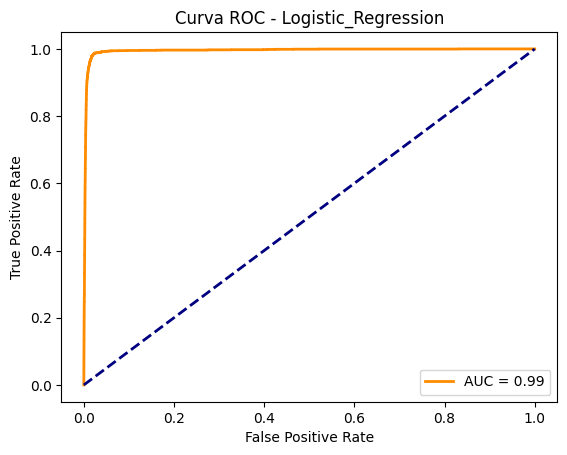

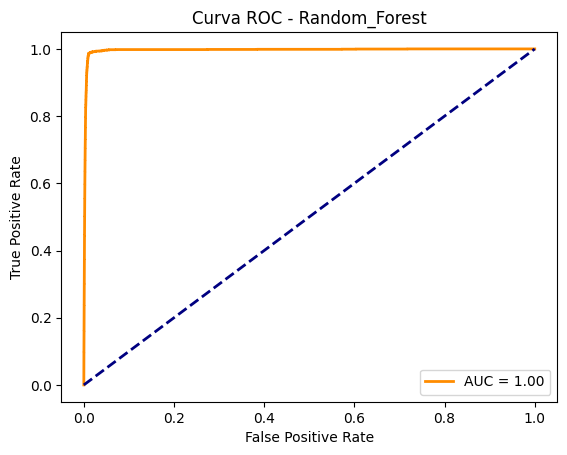

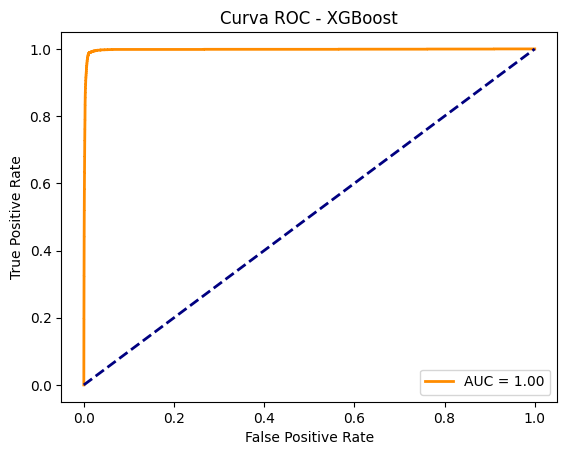

{}

In [ ]:
# Se encontra em ./exploratoryanalysis.py
# Esta função mostrará a Curva ROC, essa ferramenta fornece uma visão ampla da capacidade de um modelo de separar as classes positivas e negativas, variando o limiar de decisão.

def plot_roc_curve(models_dir="models", X=X_test, y=y_test):
    """
    Plota a Curva ROC para todos os modelos carregados.

    Parâmetros:
    models_dir: Diretório onde os modelos estão armazenados.
    X: Dados de teste.
    y: Valores reais do target.
    """
    models = {}
    model_names = ["Logistic_Regression", "Random_Forest", "XGBoost"]

    for model_name in model_names:
        model = load_model(model_name, models_dir)
        if model is not None:
            models[model_name] = model
    
    results = {}

    for name, model in models.items():
        try:
            # Aqui é calculado as probabilidades para usar na ROC
            y_prob = model.predict_proba(X)[:, 1]
            fpr, tpr, _ = roc_curve(y, y_prob)
            roc_auc = auc(fpr, tpr)

            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Curva ROC - {name}')
            plt.legend(loc='lower right')
            plt.show()
        
        except Exception as e:
            results[name] = {"Erro": str(e)}
    
    return results

plot_roc_curve()

Considerando a Curva ROC dos modelos, é muito difícil diferencia-los, somente o Logistic Regression teve a pontuação abaixo de 1.00, sendo 0.99. Podemos concluir então que os 3 modelos estão conseguindo separar de maneira fenomenal as classes positivas e negativas.

Modelo Logistic_Regression carregado de: models\Logistic_Regression.pkl
Modelo Random_Forest carregado de: models\Random_Forest.pkl
Modelo XGBoost carregado de: models\XGBoost.pkl


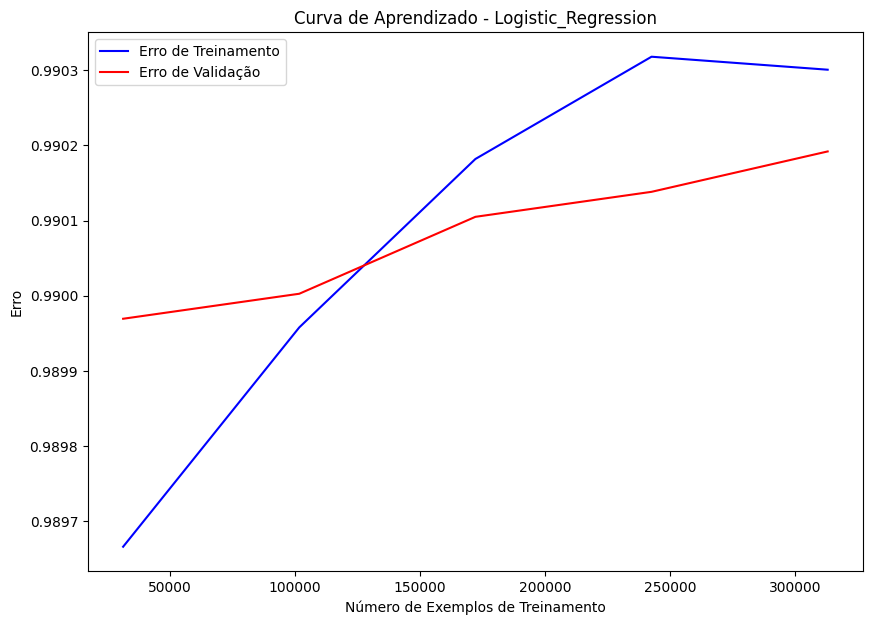

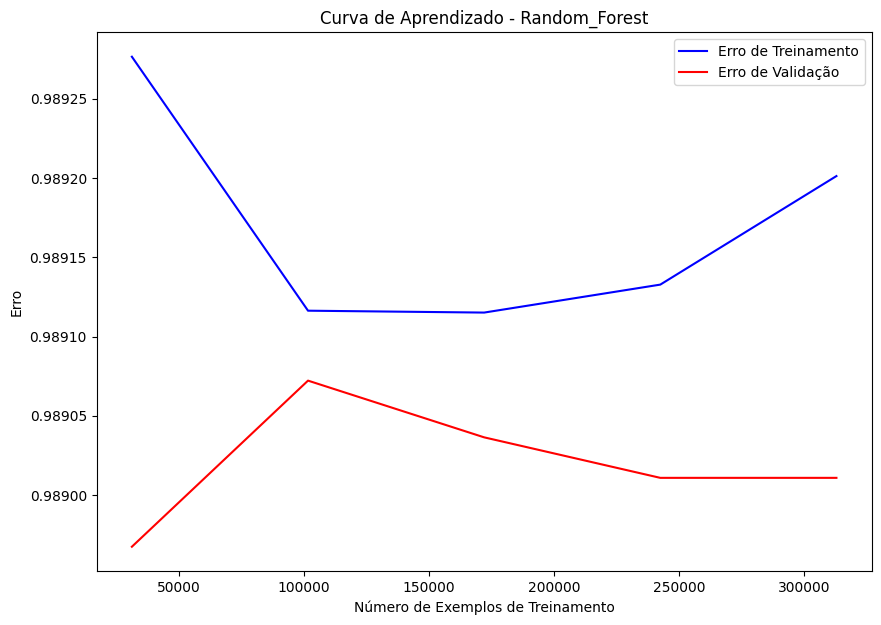

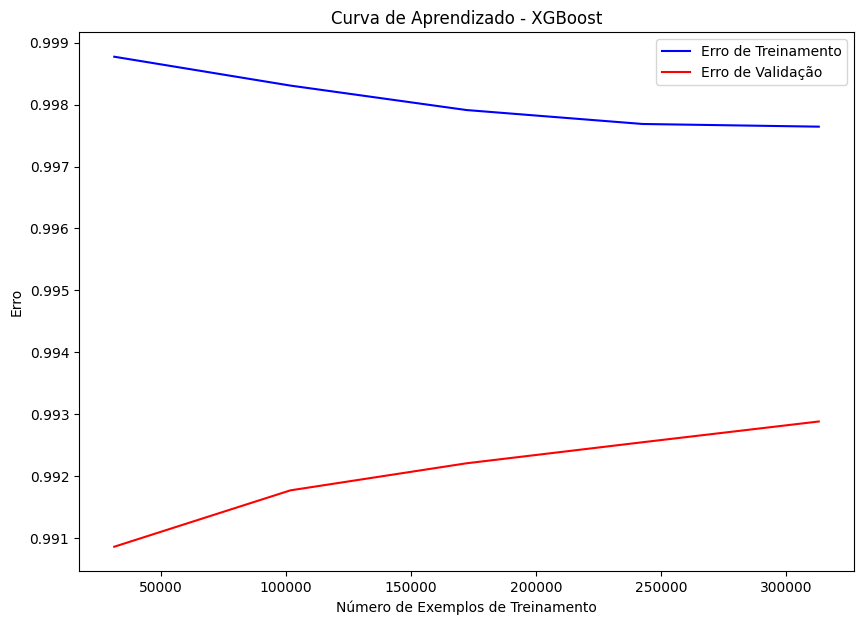

{}

In [16]:
# Se encontra em ./train_test.py
# Esta função mostra a curva de aprendizado dos modelos em relação a quantidade de exemplos de treinamento, trazendo indicativos muito importantes sobre underfit e overvit nos modelos.

def plot_learning_curve(models_dir="models", X_train=X_train, y_train=y_train):
    """
    Plota a Learning Curve para todos os modelos carregados.

    Parâmetros:
    models_dir: Diretório onde os modelos estão armazenados.
    X_train: Dados de treinamento.
    y_train: Valores reais do target de treinamento.
    """
    models = {}
    model_names = ["Logistic_Regression", "Random_Forest", "XGBoost"]

    for model_name in model_names:
        model = load_model(model_name, models_dir)
        if model is not None:
            models[model_name] = model
    
    results = {}

    for name, model in models.items():
        try:
            train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, n_jobs=-1)
            train_mean = train_scores.mean(axis=1)
            val_mean = val_scores.mean(axis=1)

            plt.figure(figsize=(10, 7))
            plt.plot(train_sizes, train_mean, label='Erro de Treinamento', color='blue')
            plt.plot(train_sizes, val_mean, label='Erro de Validação', color='red')
            plt.xlabel('Número de Exemplos de Treinamento')
            plt.ylabel('Erro')
            plt.title(f'Curva de Aprendizado - {name}')
            plt.legend()
            plt.show()
        
        except Exception as e:
            results[name] = {"Erro": str(e)}
    
    return results

plot_learning_curve()

Vamos analisar a curva de aprendizado de cada modelo:

Logistic Regression: 
As curvas de erro de treinamento e teste estão relativamente próximas, portanto o modelo não está sofrendo com overfit, entretanto como o erro de validação continua crescendo é um indicativo que o modelo está sofrendo com underfiting e também parecem estar começando a se estabilizar, diminuindo levemente à medida que os exemplos de treinamento aumentam, logo adicionar mais dados não irá melhorar de maneira relevante a precisão.

Random Forest: 
As curvas no início mostram que o modelo sofreu com um underfitting, pois ainda não tinha tido dados o suficiente para aprender, com o tempo ele melhora mas parece atingir um limite, o que indica que ele não está mais extraindo informações úteis dos dados adicionais, tendo em vista que os erros no erro de treinamento voltam a aumentar no final, indica que o modelo começou a sofrer com overfitting.

XGBoost:
As cruvas mostram que o modelo está claramente sofrendo de overfitting pois o erro de treinamento está muito baixo e o erro de validação está crescendo constantemente.

Considerando as curvas de aprendizado o Random Forest parece ser a escolha mais equilibrada entre os modelos.


Modelo Logistic_Regression carregado de: models\Logistic_Regression.pkl
Modelo Random_Forest carregado de: models\Random_Forest.pkl
Modelo XGBoost carregado de: models\XGBoost.pkl


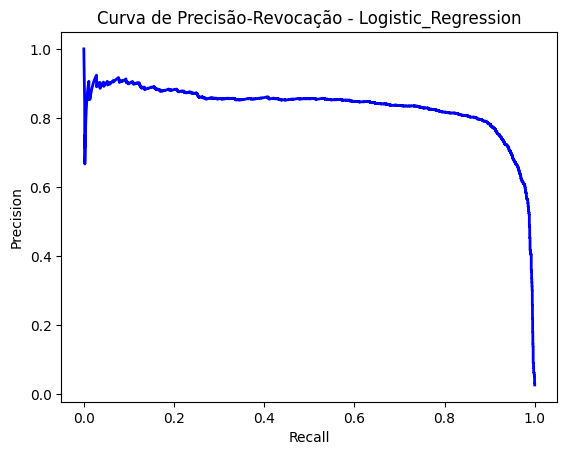

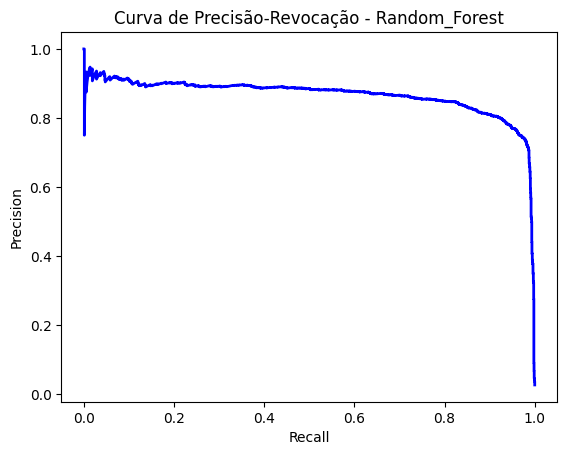

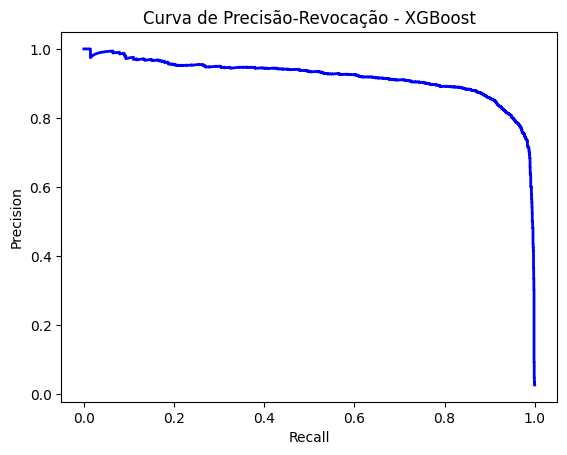

{}

In [18]:
# Se encontra em ./exploratoryanalysis.py
# Esta função mostra a relação entre precision e recall 

def plot_precision_recall_curve(models_dir="models", X=X_test, y=y_test):
    """
    Plota a Curva de Precisão-Revocação para todos os modelos carregados.

    Parâmetros:
    models_dir: Diretório onde os modelos estão armazenados.
    X: Dados de teste.
    y: Valores reais do target.
    """
    models = {}
    model_names = ["Logistic_Regression", "Random_Forest", "XGBoost"]

    for model_name in model_names:
        model = load_model(model_name, models_dir)
        if model is not None:
            models[model_name] = model
    
    results = {}

    for name, model in models.items():
        try:
            y_prob = model.predict_proba(X)[:, 1]  # Para classificação binária
            precision, recall, _ = precision_recall_curve(y, y_prob)

            plt.figure()
            plt.plot(recall, precision, color='blue', lw=2)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title(f'Curva de Precisão-Revocação - {name}')
            plt.show()
        
        except Exception as e:
            results[name] = {"Erro": str(e)}
    
    return results

plot_precision_recall_curve()

Vamos analisar as curvas de precision_recall para cada modelo:

Logistic Regression: A curva começa com uma precision alta que diminui à medida que o recall aumenta, isso sugere que o modelo não é o ideal para cenários que é crucial identificar o casos positivos, que é o foco do projeto.

Random Forest: A curva possui um incível equilibrio entre precision e recall, com uma queda suave de acordo com que o recall aumenta, isso mostra que o modelo é uma escolha muito bem equilibrada, onde se mantém uma boa precision sem sacrificar o recall.

XGBoost: A curva iniciam com o precision mais alto entre todos os modelos mas cai controladamente a medida que o recall aumenta, isso mostra que o modelo consegue manter uma boa precisão mesmo com valores de recall mais elevados, mostrando ser uma boa escolha para momentos críticos.

Tendo essa análie em mãos, o XGBoost é a melhor escolha para o nosso contexto, pois ele mantém uma a precision mais alta por um pouco mais de tempo, sendo assim, pegando melhor os casos positivos e como teve pouca variância no gráfico, o modelo continuaria equilibrado mesmo com cenários mais desbalanceados.


Agora levando todas as análises em conta, podemos concluir que para essa task em específico o melhor modelo a ser utilizado é o XGBoost, por ser mais confiável com relação aos casos positivos, pois ele obteve a maior quantidade de acertos nos verdadeiros positivos e negativos e o menor número de falsos negativos, que são críticos para o objetivo do modelo. A alta precision com valores altos de recall também mostram o valor do modelo mesmo em cenários mais diveros.

Como finalmente foi decidido qual o melhor modelo para a task, iremos agora detalhar um pouco mais sobre ele e os parâmetros usados para melhor compreensão e falar sobre seus pontos fortes e fracos.

Extreme Gradient Boosting, XGBoost para os conhecidos, é um algoritmo de boosting de gradient altamente eficiênte e escalável, muito frequentemente usados em competições e testes que possuem prazos de entrega curtos, que foi um dos motivos que me motivou a utiza-lo aqui. No momento inicial eu iria utilizar o SVM que é ótimo para classificações binárias, mas devido a lentidão do algoritmo e a grande quantidade de dados que precisavam ser processado em pouco tempo, a opção selecionada foi o XGBoost.

Este são os parâmetros utilizados para o modelo, vou passar mais detalhadamente sobre cada um deles.

"XGBoost": XGBClassifier(

n_estimators=200, Esse define a quantidade de árvores que o modelo vai gerar durante o treinamento, utilizei um número não tão alto, mas pode ter sido a causa do overfit.

learning_rate=0.03, Este é a taxa de aprendizado, basicamente diz o quanto que cada árvore vai ter de contribuição para a predição final, coloquei o valor relativamente baixo por conta da quantidade de árvores.

max_depth=15,   Esse define a profundidade máxima de cada uma das árvores, árvores maiores conseguem documentar relações mais complexas entre as características , mas tambem pode causar overfit, aqui mantive a profundidade da árvore igual ao Random Forest, para tentar evitar o overfit e manter o equilibrio entre os modelos.

subsample=0.7,  Este aqui nos diz a proporção de amostras que vão ser usadas para treinar cada árvore, valores menores ajudam a previnir o overfit, no caso do nosso modelo este valor poderia ser um pouco mais baixo.

colsample_bytree=0.7, Esse define a farção de cada feature que vai ser selecionado de aleatoriamente para poder treinar cada árvore, valores baixos tendem a diminuir o overfit mas ao mesmo tempo diminui o desempenho geral do modelo

scale_pos_weight=1.0,  Este talvez seja o parâmetro mais importante usado no modelo, ele dita as sensibilidade à classe minoritária, que é necessário na nossa task, pois temos muito mais valores negativos na classe MEDICAL_ATTN do que positivos.

eval_metric='logloss',  Aqui define a métrica de avaliação que vai ser usada durante o treinamento do modelo, o logloss é a métrica quase "padrão" quando o modelo é utilizado para classificações binárias, que é o caso do projeto.

tree_method='hist',  Esse define o metodo que vai ser utilizado para construir as árvores, usei histograma para acelerar o treinamento, pois ele é muito mais eficiente em conjuntos de dados maiores

random_state=42, Esse aqui é onde setamos a seed do modelo, 42, nós sabemos que a seed sempre tem que ser 42.
        
n_jobs=-1 Aqui nós escolhemos a quantidade de threads que vão ser utilizadas para o treinamento do modelo, -1 significa que durante o treinamento vão ser utilizados todos os núcleos de CPU disponíveis.
)

Pontos fortes do meu modelo:

--Cumpre bem o objetivo do projeto em todos os aspectos.

--Possui uma alta precisão mesmo em cenários de recall alto.

--Boa confiabilidade nos resultados, pois entregou o menor número de negativos.

--Boa robustez para o contexto da task pois entregou menos falsos negativos, que são catastróficos para o objetivo do modelo.

--Extremamente eficiente mesmo com dados complexos e volumosos.

--Muito flexivel com relação a hiperparâmetros para lidar com o overfit atual.

Pontos fracos do meu modelo:

--Não foram feitas múltiplas épocas durante o treinamento.

--Não foi amplamente testado com mais dados diferentes.

--Overfit gradual e constante, se mais dados fossem utilizdos o modelo possívelmente cometeria mais erros (mas isso precisaria ser testado, talvez ele estabilize em algum ponto e quem sabe até diminuia o erro, mas acredito não ser tão provável)

--Menos interprétavel que os modelos lineares, o fácil entendimento se deu devido ao pré-processamento dos dados.

--Sensível ao ajuste dos hiperparâmetros